In [26]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Análisis y Tratamiento de Outliers en la Variable Objetivo

En este notebook se analiza la distribución de la variable objetivo (CompTotal) y se implementan diversas técnicas para identificar y tratar valores atípicos. A partir de un análisis visual y estadístico, se identificó una distribución asimétrica positiva con valores extremos que podrían afectar el rendimiento del modelo predictivo. Inicialmente, se evaluaron métodos como el rango intercuartílico (IQR), percentiles y clustering (K-Means) para segmentar los datos y tratar outliers. Sin embargo, la segmentación por clústeres resultó en un tamaño de muestra insuficiente para entrenar modelos robustos. 

Finalmente, se adoptó el método de percentiles, estableciendo un rango entre 15,876 y 120,000 euros, para balancear la eliminación de valores extremos y preservar la representatividad de los datos. Este notebook establece un marco claro para preparar los datos y fundamentar decisiones clave en el pipeline de modelado. 

In [47]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [ ]:
nombres=df.drop(['CompTotal'], axis=1).columns

In [3]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Siguintes pasos:
1. Exploración y Análisis de Datos (EDA - Exploratory Data Analysis)

a) Estadística Descriptiva:

In [ ]:
df.describe()

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net),LanguageW

Para comprender mejor la distribución de la variable objetivo 'target' (salario), se ha generado un gráfico de densidad utilizando la función `kdeplot` de la biblioteca `seaborn`. 

El gráfico resultante muestra una *distribución asimétrica positiva*, con una mayor concentración de salarios entre 0 y 100.000 y una cola que se extiende hacia valores más altos, llegando hasta aproximadamente 400.000.

Esta visualización permite extraer las siguientes conclusiones:

- **Asimetría positiva**: La distribución presenta un sesgo hacia la derecha, lo que indica que la mayoría de los salarios son relativamente bajos, mientras que hay una menor proporción de salarios altos.
- **Valores extremos**: La cola derecha extendida sugiere la presencia de valores atípicamente altos que podrían influir en el modelo. Se considerarán estos valores como outliers y se aplicarán técnicas estadísticas para su tratamiento.
- **Concentración de datos**: La mayor densidad se observa en el rango de 0 a 100.000, lo que indica el rango de salarios más común.
- **Valores cercanos a cero**: Se observa una pequeña concentración de valores alrededor de cero, lo que requiere una investigación más profunda para determinar su naturaleza.

Estas observaciones sugieren que podría ser beneficioso aplicar transformaciones a la variable 'target' para reducir la asimetría y mejorar el rendimiento del modelo. Además, se investigará la naturaleza de los valores cercanos a cero y se aplicarán técnicas de detección y tratamiento de outliers a los valores extremos.

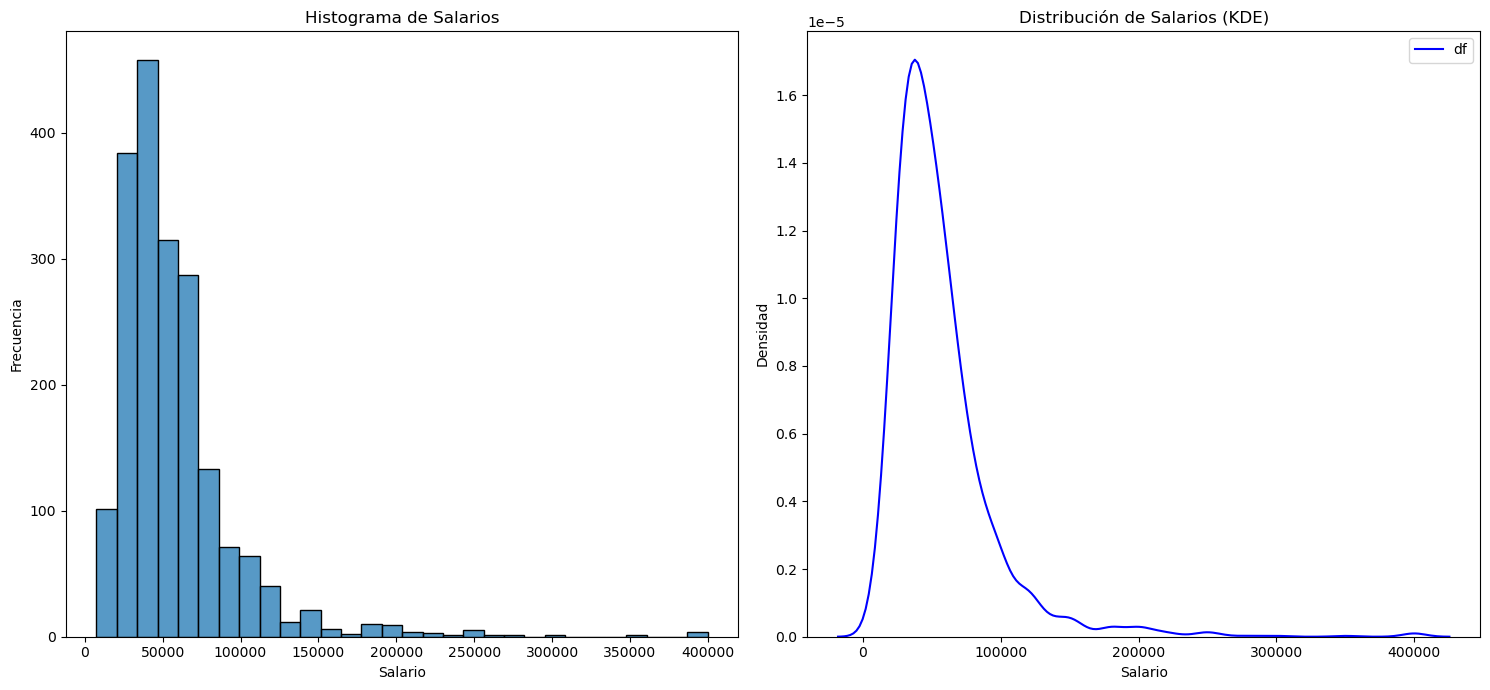

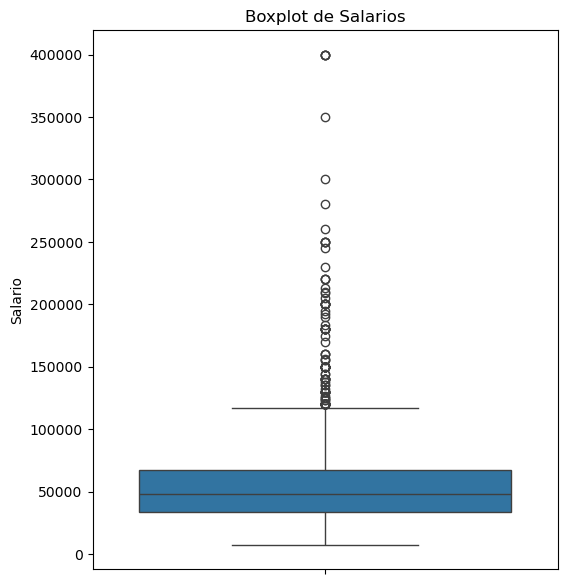

In [ ]:
# 1. Histograma y gráfico de densidad
plt.figure(figsize=(15, 7))

# Histograma
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
sns.histplot(df['CompTotal'], kde=False, bins=30)
plt.title('Histograma de Salarios')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')

# KDE Plot
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
sns.kdeplot(df['CompTotal'], label='df', color='blue')
plt.title('Distribución de Salarios (KDE)')
plt.xlabel('Salario')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Boxplot
plt.figure(figsize=(6, 7))
sns.boxplot(y=df['CompTotal'])
plt.title('Boxplot de Salarios')
plt.ylabel('Salario')
plt.show()

Para comprender mejor la distribución de la variable objetivo 'target' (salario), se ha generado un gráfico de densidad utilizando la función `kdeplot` de la biblioteca `seaborn`. 

El gráfico resultante muestra una *distribución asimétrica positiva*, con una mayor concentración de salarios entre 0 y 100.000 y una cola que se extiende hacia valores más altos, llegando hasta aproximadamente 400.000.

Esta visualización permite extraer las siguientes conclusiones:

- **Asimetría positiva**: La distribución presenta un sesgo hacia la derecha, lo que indica que la mayoría de los salarios son relativamente bajos, mientras que hay una menor proporción de salarios altos.
- **Valores extremos**: La cola derecha extendida sugiere la presencia de valores atípicamente altos que podrían influir en el modelo. Se considerarán estos valores como outliers y se aplicarán técnicas estadísticas para su tratamiento.
- **Concentración de datos**: La mayor densidad se observa en el rango de 0 a 100.000, lo que indica el rango de salarios más común.
- **Valores cercanos a cero**: Se observa una pequeña concentración de valores alrededor de cero, lo que requiere una investigación más profunda para determinar su naturaleza.

Estas observaciones sugieren que podría ser beneficioso aplicar transformaciones a la variable 'target' para reducir la asimetría y mejorar el rendimiento del modelo. Además, se investigará la naturaleza de los valores cercanos a cero y se aplicarán técnicas de detección y tratamiento de outliers a los valores extremos.

**Conclusión:**
- Tanto el histograma como el KDE plot nos permiten ver que hay una distribución asimetrica positiva, con la mayor parte de los datos concentrados entre 20000 y 80000, y con una cola hacia la derecha.
- El boxplot muestra que hay algunos valores por encima del bigote superior, que podrían considerarse como outliers, como la regla del 1.5xIQR.

In [ ]:
# 3. IQR
Q1 = df['CompTotal'].quantile(0.20)
Q3 = df['CompTotal'].quantile(0.85)
IQR = Q3 - Q1
limite_inferior_iqr = Q1 - 1.5 * IQR
limite_superior_iqr = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Límite inferior (IQR): {limite_inferior_iqr}")
print(f"Límite superior (IQR): {limite_superior_iqr}")

# 4. Percentiles
percentil_1 = df['CompTotal'].quantile(0.05)
percentil_95 = df['CompTotal'].quantile(0.95)

print(f"Percentil 1: {percentil_1}")
print(f"Percentil 95: {percentil_95}")

# Del boxplot y el IQR, ya podemos identificar algunos outliers.
# Usemos ahora los límites calculados para filtrar el DataFrame

# Filtrar outliers usando IQR
df_filtrado_iqr = df[(df['CompTotal'] >= limite_inferior_iqr) & (df['CompTotal'] <= limite_superior_iqr)]

# Filtrar outliers usando percentiles
df_filtrado_percentiles = df[(df['CompTotal'] >= percentil_1) & (df['CompTotal'] <= percentil_95)]

# Comparar tamaños de los DataFrames
print(f"\nTamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado con IQR: {df_filtrado_iqr.shape}")
print(f"Tamaño del DataFrame filtrado con percentiles: {df_filtrado_percentiles.shape}")

IQR: 50000.0
Límite inferior (IQR): -45000.0
Límite superior (IQR): 155000.0
Percentil 1: 14132.0
Percentil 95: 120000.0

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado con IQR: (1888, 397)
Tamaño del DataFrame filtrado con percentiles: (1828, 397)


Para identificar y tratar los valores atípicos en la variable 'target' (salario), se han utilizado las siguientes técnicas:

1) Visualización:
- Se ha generado un histograma y un gráfico de densidad para visualizar la distribución de los salarios.
- Se ha generado un boxplot para identificar visualmente los outliers.
2) Rango Intercuartílico (IQR):
Se ha calculado el IQR y se han considerado outliers los valores fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR], que corresponde a [-16993.75, 117396.25].
3) Percentiles:
Se han utilizado los percentiles 1 y 95 para definir los límites inferior y superior, respectivamente. Los valores fuera del rango [14132.0, 120000.0] se han considerado outliers. 

**Interpretación y comparación:**

- IQR: Sugiere un límite superior de 155000 euros.
- Percentiles: Sugieren un rango entre 14132 y 120000 euros (con los percentiles 1 y 95).

- Elección del límite inferior:
    - El percentil 1 (14,132) está por debajo de mi límite mínimo establecido por convenio (15876,00). Usaré el límite del convenio colectivo.
- Elección del límite superior:
    - El IQR da un límite superior más alto (155,000) que el percentil 95 (120,000).
    - Teniendo en cuenta el análisis visual del gráfico de densidad, éste sugiere que la "cola" empieza alrededor de 150,000.
    - Usar 120000 euros como límite superior parece un valor razonable que permite eliminar una buena parte de los outliers, eliminando tan solo el 5% de los datos, por lo que usaré el método del percentil. 

Como resultado del análisis, y como se puede ver en los gráficos, se ha decidido utilizar el método percentil para la eliminación de outliers, ya que proporciona un equilibrio entre la eliminación de valores extremos y la conservación de datos. 

Respecto del minimo, para la variable target por restricción del rubro es de 15.876,00 (por ser el salario mínimo por convenio aplicable) se ha decidido utilizar el método del percentil, pero tomando 15876,00 como minimo, y 120000.0 como máximo. Se han eliminado 176 valores, lo que representa un 9.1% del total de datos. La decisión de utilizar este método y este porcentaje de eliminación se basa en la observación de que los valores eliminados se encuentran en las colas de la distribución y su inclusión podría afectar negativamente el rendimiento del modelo.

In [ ]:
limite_inferior = 15000
limite_superior = 100000

df_filtrado = df[(df['CompTotal'] >= limite_inferior) & (df['CompTotal'] <= limite_superior)]

print(f"Tamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado: {df_filtrado.shape}")

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado: (1769, 397)


Otra técnica que se evaluó fue utilizar un 

Divido x e y para hacer train_test_split

In [5]:
y = df['CompTotal']

In [6]:
df = df.drop(columns=['CompTotal'], axis=1).copy()

In [7]:
df.shape

(1934, 396)

In [8]:
y.describe()

count      1934.000000
mean      56435.776112
std       38530.368156
min        7500.000000
25%       33402.500000
50%       48000.000000
75%       67000.000000
max      400000.000000
Name: CompTotal, dtype: float64

### Modelo de Machine Learning: Selección y Ajuste

Tras un análisis exploratorio inicial, se procedió a entrenar y evaluar diversos modelos de machine learning para la predicción de salarios. Se probaron inicialmente modelos de regresión lineal y polinomial, y posteriormente modelos más complejos como Random Forest y XGBoost. Si bien los modelos más avanzados, como Random Forest y XGBoost, mostraron una mejora en las métricas de evaluación con respecto a los modelos lineales, el rendimiento general no alcanzó los niveles deseados, evidenciado por un R² que, si bien positivo, se mantuvo por debajo de valores que indicaran un ajuste óptimo.

Un análisis detallado de las métricas y la distribución de los salarios sugirió que la dispersión de los datos podría estar dificultando la capacidad de los modelos para capturar patrones y relaciones subyacentes. La distribución de salarios presenta una asimetría positiva, con una concentración significativa de valores en el rango inferior y una cola extendida hacia valores más altos, que se corresponde a una minoría de casos. El análisis exploratorio de la variable objetivo ('target'), que representa el salario anual, reveló una dispersión considerable de los datos:

In [10]:
y.describe()

count      1934.000000
mean      56435.776112
std       38530.368156
min        7500.000000
25%       33402.500000
50%       48000.000000
75%       67000.000000
max      400000.000000
Name: CompTotal, dtype: float64

El gráfico de la distribución de la variable objetivo muestra también una clara asimetría, con una concentración de valores en el rango inferior y una cola extendida hacia valores más altos.

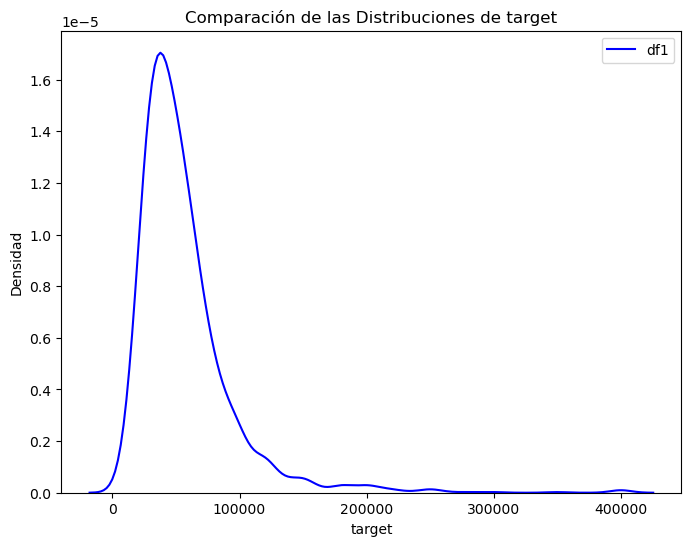

In [11]:
# Visualización
plt.figure(figsize=(8, 6))
sns.kdeplot(y, label='df1', color='blue')
plt.title('Comparación de las Distribuciones de target')
plt.xlabel('target')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Esta configuración plantea un desafío para los modelos de *machine learning*, que pueden tener dificultades para generalizar a partir de datos tan heterogéneos.

#### Estrategia de Modelado con Dos Grupos

En vista de la dispersión observada y del análisis de la distribución de los datos, se decidió implementar una estrategia de modelado diferenciada, que consiste en la creación de dos modelos distintos. El primero se enfoca en el subconjunto de datos que corresponde a salarios que se consideran dentro de un rango "normal" o más frecuente, mientras que el segundo modelo se entrena con los datos correspondientes a salarios significativamente más altos, que podrían considerarse atípicos en comparación con el grueso de la distribución. La hipótesis subyacente es que los factores que determinan los salarios en estos dos rangos pueden ser diferentes y, por lo tanto, requieren modelos distintos para su correcta predicción.

**Metodología para la División en Grupos**

Para segmentar el conjunto de datos en dos grupos, se evaluaron varios métodos:

- *Umbral Fijo*: Establecer un límite arbitrario, como por ejemplo, 100,000 unidades monetarias. Este método es directo, pero carece de fundamentación estadística y depende de una elección discrecional.
- *Percentiles*: Dividir los datos basándose en percentiles, ajustando el punto de corte (por ejemplo, percentil 90, 85, etc.) para optimizar la distribución resultante. Este enfoque es adaptable, pero la elección del percentil sigue siendo, en cierta medida, arbitraria.
- *Desviación Estándar*: Clasificar como "salarios altos" aquellos que se sitúan a 2 o 3 desviaciones estándar por encima de la media. Este método se basa en la dispersión de los datos, pero asume una distribución aproximadamente normal, lo cual no se cumple estrictamente en este - caso.
- *Clustering*: Aplicar un algoritmo de clustering para identificar agrupaciones naturales en los datos, permitiendo que el propio algoritmo determine los límites entre los grupos basándose en la similitud de los salarios.
Implementación del Clustering para la Segmentación

Se optó por implementar la técnica de clustering mediante el algoritmo K-Means para segmentar los datos. Para ello, se seleccionó la columna de salarios del DataFrame y se escalaron los datos utilizando StandardScaler para asegurar que la magnitud de los salarios no influyera de manera desproporcionada en el proceso de clustering.

Tengo que cargar los datos nuevamente, porque antes estaban escalados 

In [16]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [17]:
# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)

## Segmentación de Datos mediante Clustering

El objetivo de esta segmentación es mejorar la capacidad predictiva de los modelos de machine learning al permitirles aprender patrones específicos de cada grupo.

Metodología de Clustering

Se empleó el algoritmo K-Means para la segmentación de los datos, utilizando la variable CompTotal (salario anual total) como base para la agrupación. Se realizaron pruebas iniciales con dos clústeres, con la intención de separar los datos en grupos de salarios "normales" y "altos". Sin embargo, el análisis de la distribución resultante reveló que un clúster capturaba la gran mayoría de los datos, mientras que el otro agrupaba una cantidad reducida de observaciones con salarios significativamente más elevados.

Para refinar la segmentación, se incrementó el número de clústeres a cuatro en el algoritmo K-Means. La visualización de los cuatro clústeres resultantes, mediante el histograma que muestro a continuación, mostró una separación más clara y detallada de los datos en función del salario.

In [18]:
y = df[['CompTotal']].copy()  # 'y' ahora contiene la variable objetivo

# Escalar los datos (en este caso, solo la columna de salarios)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y) # 'y_scaled' contiene los salarios escalados

# Aplicar K-Means con 2 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

C:\Users\emita\AppData\Local\Temp\ipykernel_20456\2445942144.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels


Histograma de la distribución de salarios para los cuatro clústeres generados por K-Means.

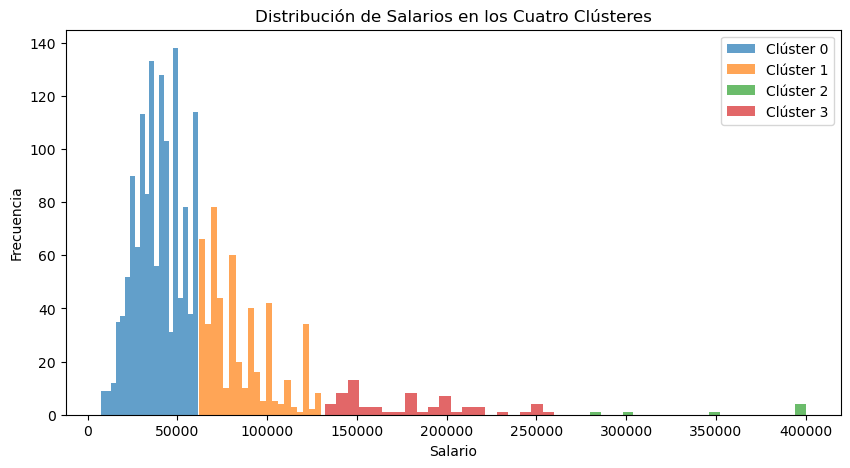

In [19]:
# Histograma de los dos grupos
plt.figure(figsize=(10, 5))
plt.hist(df_cluster_0['CompTotal'], bins=20, alpha=0.7, label='Clúster 0')
plt.hist(df_cluster_1['CompTotal'], bins=20, alpha=0.7, label='Clúster 1')
plt.hist(df_cluster_2['CompTotal'], bins=20, alpha=0.7, label='Clúster 2')
plt.hist(df_cluster_3['CompTotal'], bins=20, alpha=0.7, label='Clúster 3')
plt.xlabel("Salario")
plt.ylabel("Frecuencia")
plt.title("Distribución de Salarios en los Cuatro Clústeres")
plt.legend()
plt.show()

### Análisis de los Clústeres Resultantes

El clúster 0 concentra la mayor parte de las observaciones (1791) y presenta una distribución de salarios sesgada a la derecha, con valores que van desde aproximadamente 0 hasta 60,000. Los clústeres 1, 2 y 3, en cambio, agrupan una cantidad menor de observaciones, con rangos de salarios progresivamente más altos. El clúster 1 contiene salarios intermedios (aproximadamente entre 60,000 y 100,000), el clúster 2 agrupa salarios más altos (entre 125,000 y 200,000), y el clúster 3 representa los salarios más elevados del conjunto de datos (por encima de 350,000).

### Agrupación de Clústeres

Con el fin de mantener la estrategia inicial de modelar dos grupos diferenciados (salarios "normales" y "altos") y, al mismo tiempo, obtener un grupo de "salarios altos" con un tamaño de muestra más adecuado para el entrenamiento de modelos, se decidió agrupar los clústeres 1, 2 y 3 en un solo clúster. Esta agrupación se justifica por las siguientes razones: 1. Simplicidad: Facilita el análisis y la comparación de modelos al mantener la dicotomía inicial entre salarios "normales" y "altos".
2. Tamaño de Muestra: El grupo resultante de la unión de los clústeres 1, 2 y 3 tiene un tamaño de muestra combinado que, si bien es menor que el del clúster 0, es más adecuado para el entrenamiento de modelos que los clústeres individuales por separado.
3. Diferenciación Clara: A pesar de la agrupación, la diferencia entre el clúster 0 y el nuevo clúster "alto" (1+2+3) sigue siendo significativa en términos de rango salarial.

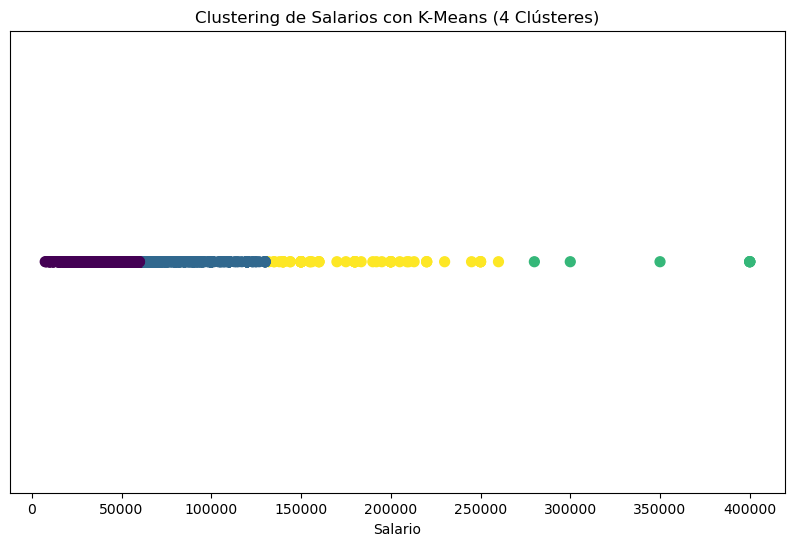

In [20]:
# Visualizar los clústeres
plt.figure(figsize=(10, 6))
plt.scatter(df['CompTotal'], [0] * len(df), c=df['cluster'], cmap='viridis', s=50)
plt.xlabel("Salario")
plt.title("Clustering de Salarios con K-Means (4 Clústeres)")
plt.yticks([])  # Ocultar el eje y
plt.show()

In [21]:
# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

C:\Users\emita\AppData\Local\Temp\ipykernel_20456\1501326124.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


#### Análisis del Clúster 0 (Salarios "Normales")

El clúster 0, que representa el grupo de salarios "normales", contiene 1366 observaciones. La Figura a continuación muestra la distribución de los salarios en este clúster, y la Tabla que le sigue presenta las estadísticas descriptivas correspondientes.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
# --- Clúster 0 ---
# Separar la variable objetivo (y) de las variables predictoras (X)
y_c0 = df_cluster_0['CompTotal']
X_c0 = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)  # Eliminar también las columnas de clustering

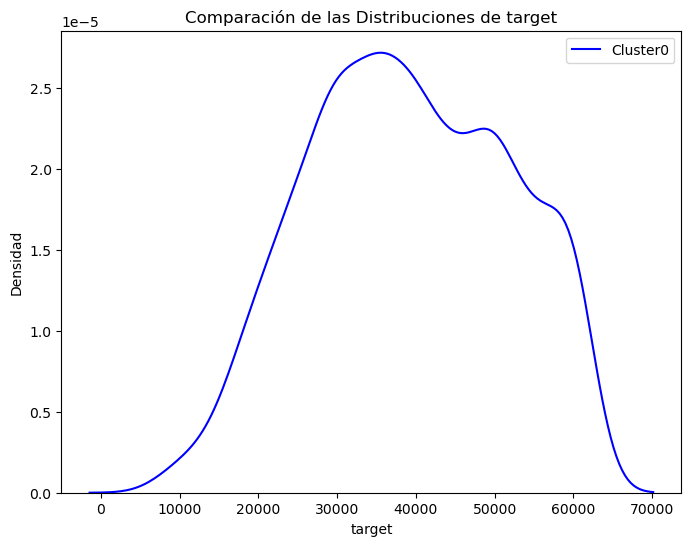

In [23]:
# Visualización
plt.figure(figsize=(8, 6))
sns.kdeplot(y_c0, label='Cluster0', color='blue')
plt.title('Comparación de las Distribuciones de target')
plt.xlabel('target')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Como se puede apreciar, la distribución de los salarios en el clúster 0 es unimodal y presenta una asimetría positiva, aunque mucho menos pronunciada que la distribución original del conjunto de datos completo. La media y la mediana son muy similares (39,109 y 39,000, respectivamente), lo que indica una distribución relativamente simétrica. El rango de salarios en este grupo (de 7,500 a 61,200) se considera adecuado para representar el segmento de salarios "normales" o más frecuentes dentro de la industria tecnológica, de acuerdo con el contexto del estudio.

In [24]:
y_c0.describe()

count     1366.000000
mean     39109.101757
std      12611.945574
min       7500.000000
25%      30000.000000
50%      39000.000000
75%      50000.000000
max      61200.000000
Name: CompTotal, dtype: float64

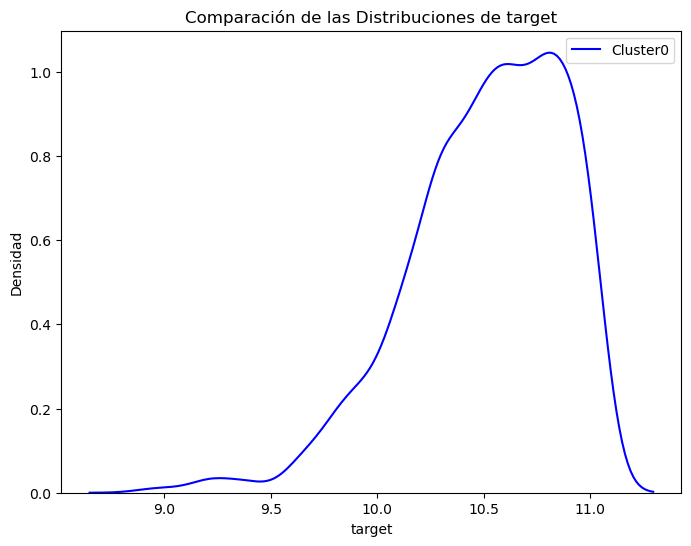

In [27]:
# Dividir en entrenamiento y prueba
X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# Transformación logarítmica de la variable objetivo
y_train_c0_log = np.log1p(y_train_c0)

# Visualizacion con transformacion logaritmica
# Visualización
plt.figure(figsize=(8, 6))
sns.kdeplot(y_train_c0_log, label='Cluster0', color='blue')
plt.title('Comparación de las Distribuciones de target')
plt.xlabel('target')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [28]:
# Creacion de variables polinomicas
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_c0_poly = poly.fit_transform(X_train_c0)
X_test_c0_poly = poly.transform(X_test_c0)

# Escalar las variables predictoras
scaler_c0 = StandardScaler()
X_train_c0_scaled = scaler_c0.fit_transform(X_train_c0_poly)
X_test_c0_scaled = scaler_c0.transform(X_test_c0_poly)

In [29]:
print((X_train_c0).shape)
print((X_test_c0).shape)
print((y_train_c0).shape)
print((y_test_c0).shape)

(1092, 396)
(274, 396)
(1092,)
(274,)


#### Análisis del Clúster 1 (Salarios "Altos")

In [30]:
# --- Clúster 1+2+3 ---
# Separar la variable objetivo (y) de las variables predictoras (X)
y_c1 = df_cluster_1['CompTotal']
X_c1 = df_cluster_1.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

y_c1.describe()

count       568.000000
mean      98105.207746
std       47070.413915
min       62000.000000
25%       70000.000000
50%       82000.000000
75%      104250.000000
max      400000.000000
Name: CompTotal, dtype: float64

El clúster 1, que representa el segmento de salarios 'altos', se compone de 568 observaciones. La distribución de los salarios en este grupo, como se observa en la Figura que sigue y se resume en la Tabla de arriba, es asimétrica positiva, con una media de 98,105 y una desviación estándar de 47,070. La presencia de valores atípicamente altos, como lo indica el salario máximo de 400,000, es una característica distintiva de este grupo.

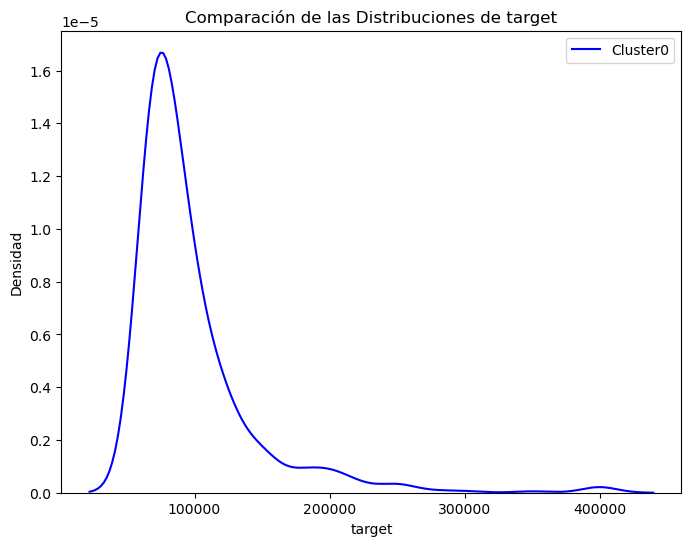

In [32]:
# Visualización
plt.figure(figsize=(8, 6))
sns.kdeplot(y_c1, label='Cluster0', color='blue')
plt.title('Comparación de las Distribuciones de target')
plt.xlabel('target')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [33]:
# Dividir en entrenamiento y prueba
X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(
    X_c1, y_c1, test_size=0.2, random_state=42
)

# Transformación logarítmica de la variable objetivo
y_train_c1_log = np.log1p(y_train_c1)

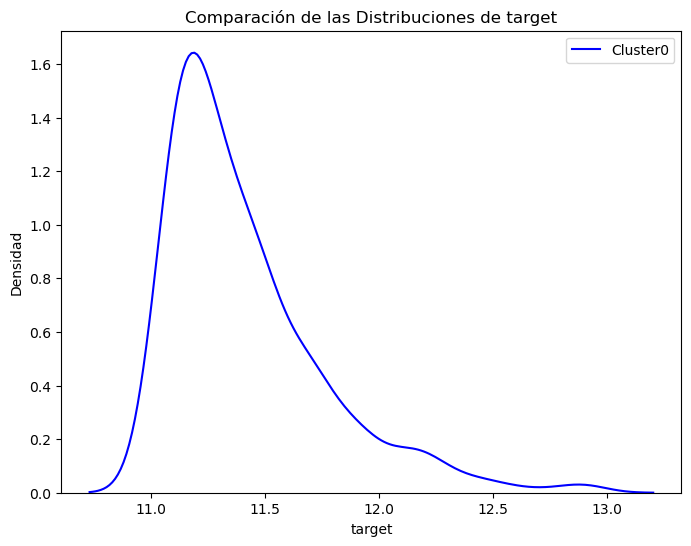

In [34]:
# Visualizacion con transformacion logaritmica
# Visualización
plt.figure(figsize=(8, 6))
sns.kdeplot(y_train_c1_log, label='Cluster0', color='blue')
plt.title('Comparación de las Distribuciones de target')
plt.xlabel('target')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [36]:
# Creacion de variables polinomicas
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_c1_poly = poly.fit_transform(X_train_c1)
X_test_c1_poly = poly.transform(X_test_c1)

# Escalar las variables predictoras
scaler_c1 = StandardScaler()
X_train_c1_scaled = scaler_c1.fit_transform(X_train_c1_poly)
X_test_c1_scaled = scaler_c1.transform(X_test_c1_poly)

In [37]:
print((X_train_c1).shape)
print((X_test_c1).shape)
print((y_train_c1).shape)
print((y_test_c1).shape)

(454, 396)
(114, 396)
(454,)
(114,)


A raíz de la división realizada entre Cluster 0 y Cluster 1, podemos decir que si bien 1366 muestras son suficientes para entrenar un modelo de Machine Learning, 568 muestras para el clúster 1 son relativamente pocas, y esto podría plantear algunos desafíos:
- Mayor Riesgo de Sobreajuste: Con un conjunto de datos pequeño, es más fácil que el modelo se ajuste demasiado a los datos de entrenamiento y no generalice bien a nuevos datos.
- Dificultad para Capturar la Variabilidad: Un conjunto de datos pequeño puede no representar adecuadamente la variabilidad real de los salarios altos.
- Evaluación Menos Fiable: La evaluación del modelo en un conjunto de prueba pequeño puede ser menos fiable, ya que las métricas de rendimiento pueden variar mucho dependiendo de la división específica de los datos. 

Comenzaré a trabajar con un algoritmo para el Cluster0, y atenderé estos desafíos luego. 

### Análisis de variables

Pruebo con una función para analizar las colinealidades de todas las columnas entre sí, aunque sin visualización. 

In [42]:
def get_top_correlations(df, threshold=0.5):
  """
  Calcula la matriz de correlación y devuelve los pares de variables con correlación
  absoluta mayor o igual a un umbral.

  Args:
      df: DataFrame de pandas.
      threshold: Umbral de correlación absoluta (por defecto, 0.5).

  Returns:
      Un DataFrame con los pares de variables y su correlación.
  """

  # Calcular la matriz de correlación
  corr_matrix = df.corr().abs()  # Calcula la correlación absoluta

  # Seleccionar el triángulo superior de la matriz de correlación
  upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  # Encontrar los pares de variables con correlación mayor o igual al umbral
  top_corr_pairs = upper_triangle.unstack().sort_values(ascending=False)
  top_corr_pairs = top_corr_pairs[top_corr_pairs >= threshold]

  return top_corr_pairs.reset_index()

# Supongamos que 'df' es tu DataFrame
# Eliminar la columna 'target'
df_cluster_0 = df_cluster_0.drop('CompTotal', axis=1)
# Calcular las correlaciones
top_correlations = get_top_correlations(df_cluster_0, threshold=0.7)  # Puedes ajustar el umbral según tus necesidades

# Imprimir los resultados
top_correlations

,level_0,level_1,0
0,Remote_grouped_Remote/Hybrid,Remote_grouped_In-person,1.000000
1,YearsCodePro,YearsCode,0.913259
2,Age_Grouped_Joven,Age_Grouped_Adulto,0.912610
3,AIToolCurrently Using_Writing code,AIToolCurrently Using_,0.869739
4,AIBen_,AISelect,0.862783
5,AIToolCurrently Using_,AISelect,0.857314
6,AISent,AISelect,0.844418
7,NEWCollabToolsHaveWorkedWith_Rad Studio (Delph...,LanguageWantToWorkWith_Delphi,0.819894
8,AIBen_,AISent,0.805297
9,WebframeHaveWorkedWith_Phoenix,LanguageHaveWorkedWith_Elixir,0.770555


In [43]:
top_correlations

,level_0,level_1,0
0,Remote_grouped_Remote/Hybrid,Remote_grouped_In-person,1.000000
1,YearsCodePro,YearsCode,0.913259
2,Age_Grouped_Joven,Age_Grouped_Adulto,0.912610
3,AIToolCurrently Using_Writing code,AIToolCurrently Using_,0.869739
4,AIBen_,AISelect,0.862783
5,AIToolCurrently Using_,AISelect,0.857314
6,AISent,AISelect,0.844418
7,NEWCollabToolsHaveWorkedWith_Rad Studio (Delph...,LanguageWantToWorkWith_Delphi,0.819894
8,AIBen_,AISent,0.805297
9,WebframeHaveWorkedWith_Phoenix,LanguageHaveWorkedWith_Elixir,0.770555
